# NeurIPS_Open-Polymer-Prediction-2025

### Goal 
Predicting polymer properties with machine learning to accelerate sustainable materials research.

### Data
In this competition, your task is to use polymer structure data (SMILES) to predict five key chemical properties derived from molecular dynamics simulation: glass transition temperature (Tg), fractional free volume (FFV), thermal conductivity (Tc), polymer density, and radius of gyration (Rg). Successfully predicting these properties is crucial for scientists to accelerate the design of novel polymers with targeted characteristics, which can be used in various applications.

In [90]:
#import
import numpy as np
import pandas as pd
from rdkit import Chem
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, DataStructs

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, KFold

In [2]:
def generate_2d_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return {desc_name: func(mol) for desc_name, func in Descriptors.descList}

In [3]:
def generate_3d_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None 
    mol = Chem.AddHs(mol)  
    try:
        AllChem.EmbedMolecule(mol, AllChem.ETKDG())
        AllChem.UFFOptimizeMolecule(mol)
        descriptors_3d = {
            "radius_of_gyration": rdMolDescriptors.CalcRadiusOfGyration(mol),
            "asphericity": rdMolDescriptors.CalcAsphericity(mol),
            "spherocity_index": rdMolDescriptors.CalcSpherocityIndex(mol),
            "eccentricity": rdMolDescriptors.CalcEccentricity(mol),
            "NPR1": rdMolDescriptors.CalcNPR1(mol),
            "NPR2": rdMolDescriptors.CalcNPR2(mol),
            "PMI1": rdMolDescriptors.CalcPMI1(mol),
            "PMI2": rdMolDescriptors.CalcPMI2(mol),
            "PMI3": rdMolDescriptors.CalcPMI3(mol)}
        return descriptors_3d
    except:
        return None 

In [4]:
datafile = pd.read_csv("processed_train.csv")

In [5]:
smiles_list = datafile["SMILES"].to_list()

In [6]:
data = []
for smiles in smiles_list:
    descriptors_2d = generate_2d_descriptors(smiles)
    descriptors_3d = generate_3d_descriptors(smiles)
    if descriptors_2d and descriptors_3d:
        combined_descriptors = {**descriptors_2d, **descriptors_3d}
        combined_descriptors["SMILES"] = smiles
        data.append(combined_descriptors)

[23:27:02] UFFTYPER: Unrecognized atom type: *_ (0)
[23:27:02] UFFTYPER: Unrecognized atom type: *_ (3)
[23:27:02] UFFTYPER: Unrecognized atom type: *_ (0)
[23:27:02] UFFTYPER: Unrecognized atom type: *_ (3)
[23:27:02] UFFTYPER: Unrecognized atom type: *_ (0)
[23:27:02] UFFTYPER: Unrecognized atom type: *_ (28)
[23:27:03] UFFTYPER: Unrecognized atom type: *_ (0)
[23:27:03] UFFTYPER: Unrecognized atom type: *_ (28)
[23:27:03] UFFTYPER: Unrecognized atom type: *_ (0)
[23:27:03] UFFTYPER: Unrecognized atom type: *_ (51)
[23:27:03] UFFTYPER: Unrecognized atom type: *_ (0)
[23:27:03] UFFTYPER: Unrecognized atom type: *_ (51)
[23:27:03] UFFTYPER: Unrecognized atom type: *_ (0)
[23:27:03] UFFTYPER: Unrecognized atom type: *_ (25)
[23:27:03] UFFTYPER: Unrecognized atom type: *_ (0)
[23:27:03] UFFTYPER: Unrecognized atom type: *_ (25)
[23:27:03] UFFTYPER: Unrecognized atom type: *_ (0)
[23:27:03] UFFTYPER: Unrecognized atom type: *_ (40)
[23:27:04] UFFTYPER: Unrecognized atom type: *_ (0)
[23:2

In [7]:
df = pd.DataFrame(data)

In [33]:
data = datafile.merge(df,on="SMILES").drop_duplicates()

In [144]:
data.to_csv("Feature_train.csv",index=False)

### Density

In [104]:
density = data.drop(["id","SMILES","Tg","Tc","FFV","Rg"],axis=1)
density.dropna(subset=['Density'],inplace=True)

In [105]:
density.replace([np.inf, -np.inf], np.nan, inplace=True)
density.fillna(density.mean(), inplace=True) 

In [106]:
X = density.drop(["Density"],axis=1)
y =density["Density"]

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'}

cv_results = cross_validate(model, X_train,y_train, cv=cv,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True )

train_rmse_mean = -cv_results['train_rmse'].mean()
train_rmse_std = cv_results['train_rmse'].std()
train_r2_mean = cv_results['train_r2'].mean()
train_r2_std = cv_results['train_r2'].std()
test_rmse_mean = -cv_results['test_rmse'].mean()
test_rmse_std = cv_results['test_rmse'].std()
test_r2_mean = cv_results['test_r2'].mean()
test_r2_std = cv_results['test_r2'].std()

print("Cross-Validation Performance:")
print(f"Training RMSE: {train_rmse_mean:.4f} (±{train_rmse_std:.4f})")
print(f"Training R²: {train_r2_mean:.4f} (±{train_r2_std:.4f})")
print(f"Validation RMSE: {test_rmse_mean:.4f} (±{test_rmse_std:.4f})")
print(f"Validation R²: {test_r2_mean:.4f} (±{test_r2_std:.4f})\n")

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("Final Test Performance:")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")

Cross-Validation Performance:
Training RMSE: 0.0007 (±0.0000)
Training R²: 1.0000 (±0.0000)
Validation RMSE: 0.0808 (±0.0262)
Validation R²: 0.6578 (±0.2405)

Final Test Performance:
RMSE: 0.0443
R²: 0.8999


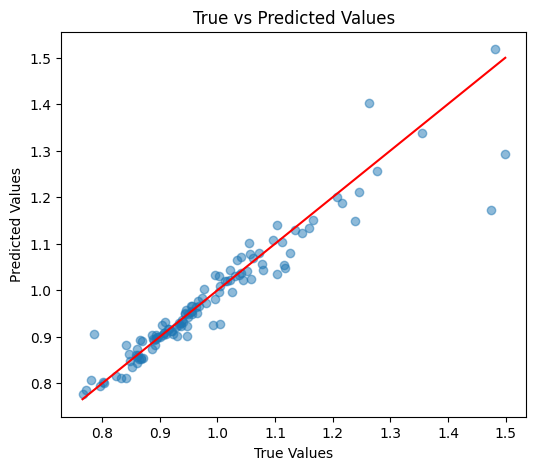

In [112]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

##### Top 20 features

<BarContainer object of 20 artists>

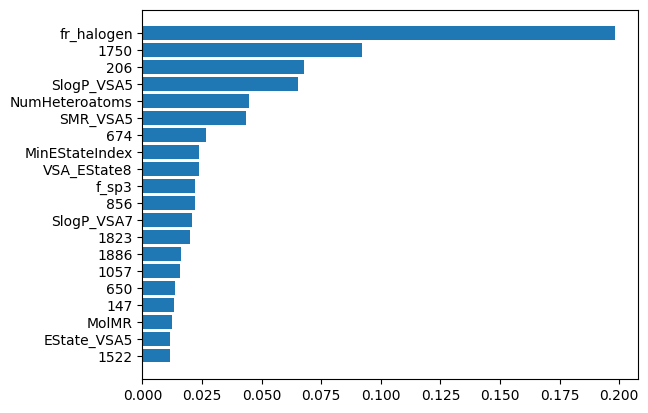

In [113]:
idx = model.feature_importances_.argsort()
plt.barh(X_train.columns[idx][2256:2276],model.feature_importances_[idx][2256:2276])

### Sub structure visualization

### Hyperparameter Optimization

### SHAP

### Tc

In [114]:
tc = data.drop(["id","SMILES","Tg","Density","FFV","Rg"],axis=1)
tc.dropna(subset=['Tc'],inplace=True)

In [115]:
tc.replace([np.inf, -np.inf], np.nan, inplace=True)
tc.fillna(tc.mean(), inplace=True) 

In [120]:
X = tc.drop(["Tc"],axis=1)
y =tc["Tc"]

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'}

cv_results = cross_validate(model, X_train,y_train, cv=cv,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True )

train_rmse_mean = -cv_results['train_rmse'].mean()
train_rmse_std = cv_results['train_rmse'].std()
train_r2_mean = cv_results['train_r2'].mean()
train_r2_std = cv_results['train_r2'].std()
test_rmse_mean = -cv_results['test_rmse'].mean()
test_rmse_std = cv_results['test_rmse'].std()
test_r2_mean = cv_results['test_r2'].mean()
test_r2_std = cv_results['test_r2'].std()

print("Cross-Validation Performance:")
print(f"Training RMSE: {train_rmse_mean:.4f} (±{train_rmse_std:.4f})")
print(f"Training R²: {train_r2_mean:.4f} (±{train_r2_std:.4f})")
print(f"Validation RMSE: {test_rmse_mean:.4f} (±{test_rmse_std:.4f})")
print(f"Validation R²: {test_r2_mean:.4f} (±{test_r2_std:.4f})\n")

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("Final Test Performance:")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")

Cross-Validation Performance:
Training RMSE: 0.0008 (±0.0001)
Training R²: 0.9999 (±0.0000)
Validation RMSE: 0.0434 (±0.0057)
Validation R²: 0.7598 (±0.0579)

Final Test Performance:
RMSE: 0.0463
R²: 0.7222


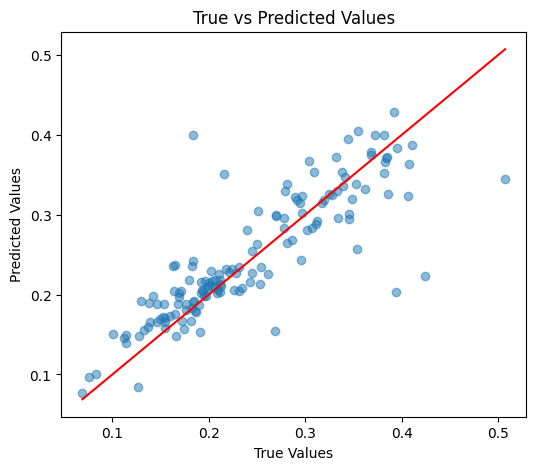

In [123]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

<BarContainer object of 20 artists>

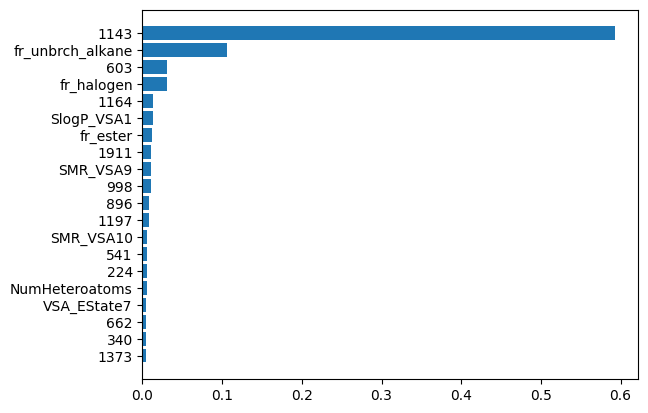

In [124]:
idx = model.feature_importances_.argsort()
plt.barh(X_train.columns[idx][2256:2276],model.feature_importances_[idx][2256:2276])

### Sub structure visualization

### Hyperparameter Optimization

### SHAP

### Tg

In [125]:
tg = data.drop(["id","SMILES","Tc","Density","FFV","Rg"],axis=1)
tg.dropna(subset=['Tg'],inplace=True)

In [126]:
tg.replace([np.inf, -np.inf], np.nan, inplace=True)
tg.fillna(tg.mean(), inplace=True) 

In [128]:
X = tg.drop(["Tg"],axis=1)
y =tg["Tg"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [129]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'}

cv_results = cross_validate(model, X_train,y_train, cv=cv,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True )

train_rmse_mean = -cv_results['train_rmse'].mean()
train_rmse_std = cv_results['train_rmse'].std()
train_r2_mean = cv_results['train_r2'].mean()
train_r2_std = cv_results['train_r2'].std()
test_rmse_mean = -cv_results['test_rmse'].mean()
test_rmse_std = cv_results['test_rmse'].std()
test_r2_mean = cv_results['test_r2'].mean()
test_r2_std = cv_results['test_r2'].std()

print("Cross-Validation Performance:")
print(f"Training RMSE: {train_rmse_mean:.4f} (±{train_rmse_std:.4f})")
print(f"Training R²: {train_r2_mean:.4f} (±{train_r2_std:.4f})")
print(f"Validation RMSE: {test_rmse_mean:.4f} (±{test_rmse_std:.4f})")
print(f"Validation R²: {test_r2_mean:.4f} (±{test_r2_std:.4f})\n")

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("Final Test Performance:")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")

Cross-Validation Performance:
Training RMSE: 0.0006 (±0.0000)
Training R²: 1.0000 (±0.0000)
Validation RMSE: 74.3829 (±6.5744)
Validation R²: 0.5485 (±0.0859)

Final Test Performance:
RMSE: 65.1193
R²: 0.6195


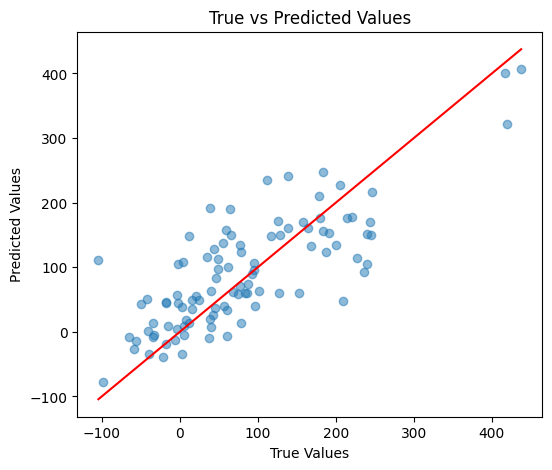

In [130]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

<BarContainer object of 20 artists>

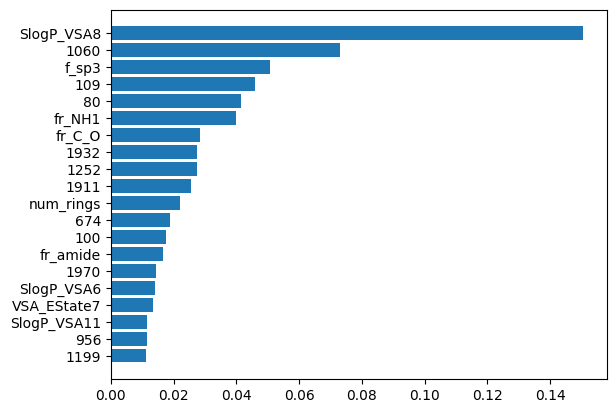

In [131]:
idx = model.feature_importances_.argsort()
plt.barh(X_train.columns[idx][2256:2276],model.feature_importances_[idx][2256:2276])

### Sub structure visualization

### Hyperparameter Optimization

### SHAP

### Rg

In [132]:
rg = data.drop(["id","SMILES","Tc","Density","FFV","Tg"],axis=1)
rg.dropna(subset=['Rg'],inplace=True)

In [133]:
rg.replace([np.inf, -np.inf], np.nan, inplace=True)
rg.fillna(rg.mean(), inplace=True) 

In [134]:
X = rg.drop(["Rg"],axis=1)
y =rg["Rg"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [135]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'}

cv_results = cross_validate(model, X_train,y_train, cv=cv,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True )

train_rmse_mean = -cv_results['train_rmse'].mean()
train_rmse_std = cv_results['train_rmse'].std()
train_r2_mean = cv_results['train_r2'].mean()
train_r2_std = cv_results['train_r2'].std()
test_rmse_mean = -cv_results['test_rmse'].mean()
test_rmse_std = cv_results['test_rmse'].std()
test_r2_mean = cv_results['test_r2'].mean()
test_r2_std = cv_results['test_r2'].std()

print("Cross-Validation Performance:")
print(f"Training RMSE: {train_rmse_mean:.4f} (±{train_rmse_std:.4f})")
print(f"Training R²: {train_r2_mean:.4f} (±{train_r2_std:.4f})")
print(f"Validation RMSE: {test_rmse_mean:.4f} (±{test_rmse_std:.4f})")
print(f"Validation R²: {test_r2_mean:.4f} (±{test_r2_std:.4f})\n")

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("Final Test Performance:")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")

Cross-Validation Performance:
Training RMSE: 0.0008 (±0.0000)
Training R²: 1.0000 (±0.0000)
Validation RMSE: 2.7905 (±0.2073)
Validation R²: 0.6386 (±0.0472)

Final Test Performance:
RMSE: 2.3722
R²: 0.7130


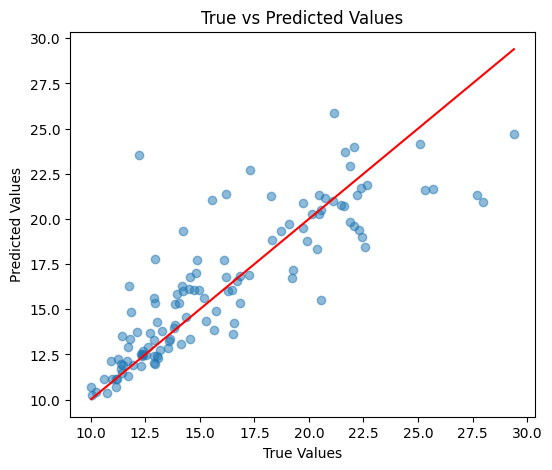

In [136]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

<BarContainer object of 20 artists>

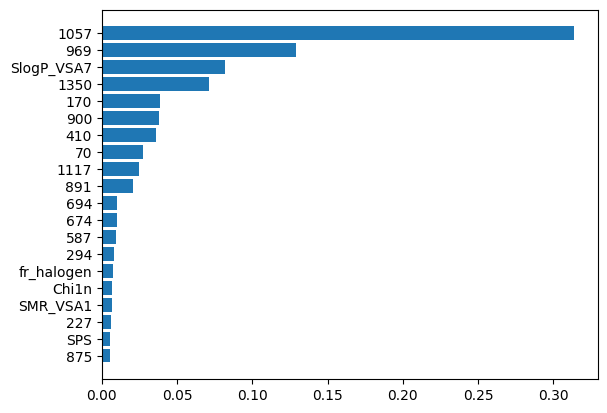

In [137]:
idx = model.feature_importances_.argsort()
plt.barh(X_train.columns[idx][2256:2276],model.feature_importances_[idx][2256:2276])

### Sub structure visualization

### Hyperparameter Optimization

### SHAP

### FFV

In [138]:
ffv = data.drop(["id","SMILES","Tc","Density","Rg","Tg"],axis=1)
ffv.dropna(subset=['FFV'],inplace=True)

In [139]:
ffv.replace([np.inf, -np.inf], np.nan, inplace=True)
ffv.fillna(ffv.mean(), inplace=True) 

In [140]:
X = ffv.drop(["FFV"],axis=1)
y =ffv["FFV"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [141]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'}

cv_results = cross_validate(model, X_train,y_train, cv=cv,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True )

train_rmse_mean = -cv_results['train_rmse'].mean()
train_rmse_std = cv_results['train_rmse'].std()
train_r2_mean = cv_results['train_r2'].mean()
train_r2_std = cv_results['train_r2'].std()
test_rmse_mean = -cv_results['test_rmse'].mean()
test_rmse_std = cv_results['test_rmse'].std()
test_r2_mean = cv_results['test_r2'].mean()
test_r2_std = cv_results['test_r2'].std()

print("Cross-Validation Performance:")
print(f"Training RMSE: {train_rmse_mean:.4f} (±{train_rmse_std:.4f})")
print(f"Training R²: {train_r2_mean:.4f} (±{train_r2_std:.4f})")
print(f"Validation RMSE: {test_rmse_mean:.4f} (±{test_rmse_std:.4f})")
print(f"Validation R²: {test_r2_mean:.4f} (±{test_r2_std:.4f})\n")

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("Final Test Performance:")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")

Cross-Validation Performance:
Training RMSE: 0.0008 (±0.0000)
Training R²: 0.9992 (±0.0001)
Validation RMSE: 0.0129 (±0.0028)
Validation R²: 0.8007 (±0.0763)

Final Test Performance:
RMSE: 0.0112
R²: 0.8683


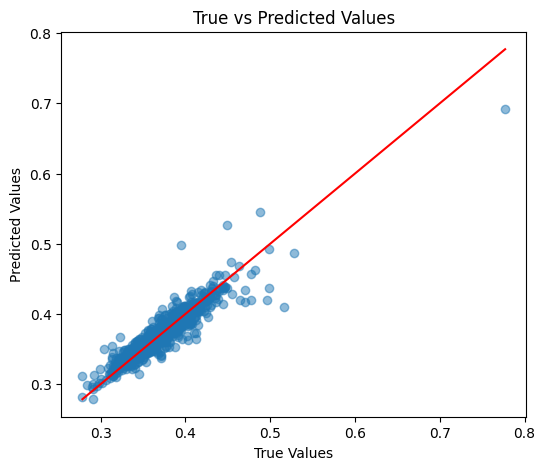

In [142]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

<BarContainer object of 20 artists>

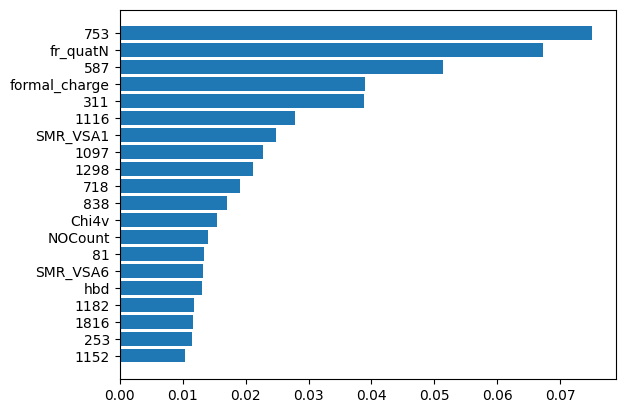

In [143]:
idx = model.feature_importances_.argsort()
plt.barh(X_train.columns[idx][2256:2276],model.feature_importances_[idx][2256:2276])

### Sub structure visualization

### Hyperparameter Optimization

### SHAP